# Classificação de Notícias Com BERT e Cadeias de Markov

Este notebook compara duas formas de classificar categorias de notícias:
1. Um modelo "transformer" baseado em BERT com pre-treinamento e fine-tuning.
2. Um classificar de cadeia de Markov.

In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import defaultdict, Counter
import tensorflow as tf
import json
os.environ["KERAS_BACKEND"] = "torch"  
import keras_hub
import keras
from keras import layers
from keras.layers import TextVectorization

/opt/anaconda3/envs/sbc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuração

In [2]:
@dataclass
class Config:
    """Hiperparâmetros do nosso modelo BERT"""
    MAX_LEN = 128 
    BATCH_SIZE = 32 
    LR = 0.001
    VOCAB_SIZE = 20000
    EMBED_DIM = 128
    NUM_HEAD = 8 
    FF_DIM = 128
    NUM_LAYERS = 1 
    NUM_CATEGORIES = 10 
    NUM_EPOCHS = 20

config = Config()

## Carregar e Pre-processar os Dados

In [3]:
# Baixar o Dataset
# !wget https://www.kaggle.com/datasets/rmisra/news-category-dataset/download -O news-category-dataset.zip
# !unzip -q news-category-dataset.zip

In [4]:
def load_news_category_dataset(filepath='News_Category_Dataset_v3.json', num_categories=10):
    """
    Carregador e preprocessor o dataset.
    
    Args:
        filepath: Path do arquivo JSON
        num_categories: Número de categorias para incluir
    
    Retorna:
        DataFrame com dados processadores
    """
    # Carregar os dados
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    
    # Converter para DataFrame
    df = pd.DataFrame(data)
    
    # Combinar headline e a descrição para ter mais contexto
    df['text'] = df['headline'] + ' ' + df['short_description']
    
    # Top N categorias
    top_categories = df['category'].value_counts().nlargest(num_categories).index.tolist()
    df_filtered = df[df['category'].isin(top_categories)]
    
    # Criar codificador de labels
    category_mapping = {category: idx for idx, category in enumerate(top_categories)}
    df_filtered['category_id'] = df_filtered['category'].map(category_mapping)
    
    config.NUM_CATEGORIES = len(top_categories)
    
    print(f"{len(df_filtered)} artigos de {num_categories} categorias")
    return df_filtered, category_mapping

df, category_mapping = load_news_category_dataset()
df[['headline', 'category', 'category_id']].head()

124787 artigos de 10 categorias


/var/folders/75/f51mxs852c1_yjmjpr_rjcph0000gn/T/ipykernel_94145/4064416217.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['category_id'] = df_filtered['category'].map(category_mapping)


,headline,category,category_id
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,5
20,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,2
21,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,0
24,‘Beautiful And Sad At The Same Time’: Ukrainia...,POLITICS,0
28,James Cameron Says He 'Clashed' With Studio Be...,ENTERTAINMENT,2


In [5]:
# Criar os datasets de train e test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category_id'])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Combinar os dados para vetorização
all_data = pd.concat([train_df, test_df], ignore_index=True)

print(f"Tamanho do dataset de treino: {len(train_df)}")
print(f"Tamanho do dataset de teste: {len(test_df)}")

Tamanho do dataset de treino: 99829
Tamanho do dataset de teste: 24958


## Vetorização de texto

In [6]:
def custom_standardization(input_data):
    """
    Limpar e estandarizar o texto
    
    Args:
        input_data: Texto sem modificações
        
    Retorna:
        Texto limpo
    """
    lowercase = tf.strings.lower(input_data)
    # Remover tags de HTML
    stripped_html = tf.strings.regex_replace(lowercase, "<[^>]+>", " ")
    # Remover pontuação
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )

def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """
    Contruir camada de vetorização de texto
    
    Args:
      texts (list): Lista de strings (textos de input)
      vocab_size (int): Tamanho de vocabulário
      max_seq (int): Cumprimento máximo de sequências
      special_tokens (list): Lista de tokens especiais
    
    Retorna:
        Camada TextVectorization
    """
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    
    vectorize_layer.adapt(texts)
    vocab = vectorize_layer.get_vocabulary()

    # Excluir padding padrão e tokens desconhecidos nos índices 0 e 1
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    
    return vectorize_layer

# Criar camada de vetorização usando todos os dados
vectorize_layer = get_vectorize_layer(
    all_data.text.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Pegar o ID do token de máscara
mask_token_id = vectorize_layer(["[mask]"]).cpu().numpy()[0][0]
print(f"ID do token de máscara: {mask_token_id}")

Instructions for updating:
Use tf.identity with explicit device placement instead.
ID do token de máscara: 19999


In [7]:
def encode(texts):
    """
    Codificar os textos usando a camada de vetorização
    
    Args:
        texts: Lista de textos para codificar
        
    Retorna:
        array (numpy) de textos codificados
    """
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.cpu().numpy()

def get_masked_input_and_labels(encoded_texts):
    """
    Criar inputs com máscaras e labels para o pre-training do BERT MLM
    
    Args:
        encoded_texts: Sequências de texto codificadas
        
    Retorna:
        Tuple de (masked_inputs, labels, sample_weights)
    """
    # Criar máscara no input com 15% de probabilidade
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    
    # Não colocar máscara com tokens especiais (tipo os desconhecidos) com indices ≤ 2
    inp_mask[encoded_texts <= 2] = False
    
    # Inicializar os labels com -1 (que são ignorados na calculação da perda)
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    
    # Estabelecer os labels verdadeiros para as máscaras
    labels[inp_mask] = encoded_texts[inp_mask]

    # Criar uma cópia dos textos codificados para colocar as máscaras
    encoded_texts_masked = np.copy(encoded_texts)
    
    # Substituir 90% dos tokens mascarados com o token [MASK]
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[inp_mask_2mask] = mask_token_id
    
    # Substituir 10% dos tokens mascarados com tokens aleatórios
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )
    
    # Pesos de amostra para a calculação da perda (0 para tokens não mascarados)
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0
    
    # Textos codificados originais como ground truth
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

In [8]:
# Preparar dados para o classificador
x_train = encode(train_df.text.values)
y_train = train_df.category_id.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

x_test = encode(test_df.text.values)
y_test = test_df.category_id.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)

# Evaluar o modelo com texto sem pre-processamento
test_raw_classifier_ds = test_df

# Preparar dados para pre-treinamento
x_all_texts = encode(all_data.text.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_texts
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

## BERT Transformer Implementation

Let's implement the BERT transformer model for masked language modeling pre-training.

In [9]:
def bert_module(query, key, value, i):
    """
    Bloco de Transformer BERT
    
    Args:
        query, key, value: Tensores de input
        i: Índice da camada
        
    Retorna:
        Output processado
    """
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name=f"encoder_{i}_multiheadattention",
    )(query, key, value)
    
    attention_output = layers.Dropout(0.1, name=f"encoder_{i}_att_dropout")(
        attention_output
    )
    
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name=f"encoder_{i}_att_layernormalization"
    )(query + attention_output)

    # Feed-forward neural network
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name=f"encoder_{i}_ffn",
    )
    ffn_output = ffn(attention_output)
    
    ffn_output = layers.Dropout(0.1, name=f"encoder_{i}_ffn_dropout")(
        ffn_output
    )
    
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name=f"encoder_{i}_ffn_layernormalization"
    )(attention_output + ffn_output)
    
    return sequence_output

loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction=None)
loss_tracker = keras.metrics.Mean(name="loss")

In [10]:
class MaskedLanguageModel(keras.Model):
    """Modelo Keras para a tarefa de MLM"""

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        """
        Computar a perda da tarefa MLM
        
        Args:
            x: Dados de input
            y: Labels
            y_pred: Predições do modelo
            sample_weight: Pesos para a calculação da perda
            
        Retorna:
            Valor da perda
        """
        loss = loss_fn(y, y_pred, sample_weight)
        loss_tracker.update_state(loss, sample_weight=sample_weight)
        return keras.ops.sum(loss)

    def compute_metrics(self, x, y, y_pred, sample_weight):
        """
        Calcular métricas para o modelo
        
        Args:
            x: Dados de input
            y: Labels
            y_pred: Predições do modelo
            sample_weight: Pesos para a calculação da perda
            
        Retorna:
            Dictionário de métricas
        """
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        """
        Retornar lista de métricas usadas pelo modelo
        
        Retorna:
            Lista de objetos de métricas
        """
        return [loss_tracker]

def create_masked_language_bert_model():
    """
    Criar modelo BERT
    
    Retorna:
        Modelo KERAS compilado
    """
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    
    position_embeddings = keras_hub.layers.PositionEmbedding(
        sequence_length=config.MAX_LEN
    )(word_embeddings)
    
    embeddings = word_embeddings + position_embeddings

    # Passar pelas camadas do transformer
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    # Camada de ouptut para predição dos tokens mascarados
    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    
    return mlm_model

In [11]:
# Criar mapeamento entre os IDs dos tokens e os tokens
id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}

class MaskedTextGenerator(keras.callbacks.Callback):
    """Callback para gerar predições de tokens mascarados durante os treinamentos"""
    
    def __init__(self, sample_tokens, top_k=5):
        """
        Initializar o callback
        
        Args:
            sample_tokens: Tokens de amostra com as máscaras
            top_k: Número de predições para mostrar
        """
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        """Converter IDs to tokens para texto"""
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        """Converter um ID de um token a sua representação string"""
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        """
        Gerar predições no final de cada época

        Args:
            epoch: época atual
            logs: logs de treinamento
        """
        prediction = self.model.predict(self.sample_tokens)

        # Encontrar as posições dos tokens mascarados
        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        # Top k predições
        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        # Printar predições
        print(f"\nMask token predictions after epoch {epoch+1}:")
        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(self.sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(self.sample_tokens[0]),
                "prediction": self.decode(tokens),
                "probability": float(v),
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            print(f"Top-{i+1}: {result['predicted mask token']} ({result['probability']:.4f})")

## Train BERT Masked Language Model

Now let's train our BERT model on the masked language modeling task.

In [12]:
# Criar uma amostra para monitorear as predições dos tokens mascarados
sample_text = "This news article is about [mask] and politics"
sample_tokens = vectorize_layer([sample_text])
generator_callback = MaskedTextGenerator(sample_tokens.cpu().numpy())

# Criar modelo BERT
bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 128, 128)  │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, 128, 128)  │     16,384 │ word_embedding[0… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128)  │          0 │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_multihea… │ (None, 128, 128)  │     66,048 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_drop… │ (None, 128, 128)  │          0 │ encoder_0_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128)  │          0 │ add[0][0],        │
│                     │                   │            │ encoder_0_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_laye… │ (None, 128, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn       │ (None, 128, 128)  │     33,024 │ encoder_0_att_la… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_drop… │ (None, 128, 128)  │          0 │ encoder_0_ffn[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 128)  │          0 │ encoder_0_att_la… │
│                     │                   │            │ encoder_0_ffn_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_laye… │ (None, 128, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm_cls (Dense)     │ (None, 128,       │  2,580,000 │ encoder_0_ffn_la… │
│                     │ 20000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,255,968 (20.05 MB)

 Trainable params: 5,255,968 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
training_times = {}
inference_times = {}

import time

start = time.time()
mlm_history = bert_masked_model.fit(
    mlm_ds, 
    epochs=config.NUM_EPOCHS,
    callbacks=[generator_callback]
)
end = time.time()
training_times['BERT_init'] = end - start

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepms/step - loss: 7.611

Mask token predictions after epoch 1:
Top-1: to (0.0316)
Top-2: a (0.0265)
Top-3: in (0.0184)
Top-4: of (0.0170)
Top-5: for (0.0167)
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 1044s 267ms/step - loss: 7.6110
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/stepms/step - loss: 6.670

Mask token predictions after epoch 2:
Top-1: is (0.0193)
Top-2: a (0.0170)
Top-3: trump (0.0134)
Top-4: this (0.0116)
Top-5: about (0.0105)
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 1062s 272ms/step - loss: 6.6709
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepms/step - loss: 6.075

Mask token predictions after epoch 3:
Top-1: talking (0.0361)
Top-2: talk (0.0354)
Top-3: truth (0.0163)
Top-4: what (0.0144)
Top-5: pence (0.0134)
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 1050s 269ms/step - loss: 6.0756
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/stepms/step - loss: 5.483

Mask token predictions after epoch 4:
Top-1: talking (0.0948)
Top-2: truth (0.0523)
Top-3: talk (0.0425)
T

## Criar e Treinar Classificador BERT

In [14]:
# Extrair a parte do codificador para transfer learning
pretrained_bert_model = keras.Model(
    bert_masked_model.input, bert_masked_model.get_layer("encoder_0_ffn_layernormalization").output
)

# Congelar as camadas do modelo BERT pre-treinado
pretrained_bert_model.trainable = False

def create_classifier_bert_model():
    """
    Criar modelo de classificação usando o modelo BERT pre-treinado
    
    Retorna:
        Modelo de classificação compilado
    """
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    sequence_output = pretrained_bert_model(inputs)

    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)

    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
    outputs = layers.Dense(config.NUM_CATEGORIES, activation="softmax")(hidden_layer)

    classifier_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.Adam()
    classifier_model.compile(
        optimizer=optimizer, 
        loss="sparse_categorical_crossentropy", 
        metrics=["accuracy"]
    )
    return classifier_model

In [15]:
classifier_model = create_classifier_bert_model()
classifier_model.summary()

Model: "classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 128, 128)       │     2,675,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,684,874 (10.24 MB)

 Trainable params: 8,906 (34.79 KB)

 Non-trainable params: 2,675,968 (10.21 MB)

In [16]:
# Treinar classificador com BERT congelado
start = time.time()
freeze_history = classifier_model.fit(
    train_classifier_ds,
    epochs=config.NUM_EPOCHS,
    validation_data=test_classifier_ds,
)
end = time.time()
training_times['Classifier_BERT'] = end - start

Epoch 1/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 94s 30ms/step - accuracy: 0.3814 - loss: 2.1996 - val_accuracy: 0.5592 - val_loss: 1.3461
Epoch 2/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 94s 30ms/step - accuracy: 0.5566 - loss: 1.3520 - val_accuracy: 0.5726 - val_loss: 1.2968
Epoch 3/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 95s 30ms/step - accuracy: 0.5685 - loss: 1.3119 - val_accuracy: 0.5811 - val_loss: 1.2659
Epoch 4/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 96s 31ms/step - accuracy: 0.5733 - loss: 1.2978 - val_accuracy: 0.5671 - val_loss: 1.3003
Epoch 5/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 98s 31ms/step - accuracy: 0.5753 - loss: 1.2874 - val_accuracy: 0.5873 - val_loss: 1.2730
Epoch 6/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 98s 32ms/step - accuracy: 0.5781 - loss: 1.2838 - val_accuracy: 0.5896 - val_loss: 1.2529
Epoch 7/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 101s 32ms/step - accuracy: 0.5777 - loss: 1.2780 - val_accuracy: 0.5970 - val_loss: 1.2224
Epoch 8/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 100s 32ms/step - accuracy: 0.5771

In [17]:
# Fine-tuning do modelo inteiro
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
classifier_model.compile(
    optimizer=optimizer, 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)

start = time.time()
finetune_history = classifier_model.fit(
    train_classifier_ds,
    epochs=config.NUM_EPOCHS,
    validation_data=test_classifier_ds,
)
end = time.time()
training_times['Finetune_BERT'] = end - start
training_times['BERT_total'] = training_times['Finetune_BERT'] + training_times['Classifier_BERT'] + training_times['BERT_init']

Epoch 1/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 182s 58ms/step - accuracy: 0.6064 - loss: 1.1839 - val_accuracy: 0.6371 - val_loss: 1.1016
Epoch 2/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 186s 60ms/step - accuracy: 0.6396 - loss: 1.0901 - val_accuracy: 0.6559 - val_loss: 1.0504
Epoch 3/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 184s 59ms/step - accuracy: 0.6597 - loss: 1.0345 - val_accuracy: 0.6713 - val_loss: 1.0101
Epoch 4/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 188s 60ms/step - accuracy: 0.6763 - loss: 0.9832 - val_accuracy: 0.6828 - val_loss: 0.9758
Epoch 5/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 190s 61ms/step - accuracy: 0.6896 - loss: 0.9446 - val_accuracy: 0.6931 - val_loss: 0.9458
Epoch 6/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 190s 61ms/step - accuracy: 0.7028 - loss: 0.9051 - val_accuracy: 0.7019 - val_loss: 0.9192
Epoch 7/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 188s 60ms/step - accuracy: 0.7134 - loss: 0.8732 - val_accuracy: 0.7114 - val_loss: 0.8952
Epoch 8/20
3120/3120 ━━━━━━━━━━━━━━━━━━━━ 188s 60ms/step - accuracy: 

## Modelo End-to-End para Evaluação

In [18]:
class ModelEndtoEnd(keras.Model):
    """Modelo End-to-end para Evaluação"""

    def evaluate(self, inputs):
        """
        Evaluar modelo em dados de input
        
        Args:
            inputs: DataFrame com texto
            
        Retorna:
            Métricas de evaluação
        """
        # Codificar texto
        features = encode(inputs.text.values)
        labels = inputs.category_id.values
    
        test_classifier_ds = (
            tf.data.Dataset.from_tensor_slices((features, labels))
            .batch(config.BATCH_SIZE)
        )
        
        return super().evaluate(test_classifier_ds)
    
    def build(self, input_shape):
        """Contruir o modelo"""
        self.built = True

In [19]:
# Create end-to-end model
def get_end_to_end(model):
    """
    Criar modelo end-to-end model para evaluação
    
    Args:
        model: Classificador Treinado
        
    Retorna:
        Model End-to-End
    """
    inputs = model.inputs[0]
    outputs = model.outputs
    end_to_end_model = ModelEndtoEnd(inputs, outputs, name="end_to_end_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    end_to_end_model.compile(
        optimizer=optimizer, 
        loss="sparse_categorical_crossentropy", 
        metrics=["accuracy"]
    )
    return end_to_end_model

In [20]:
# Criar e evaluar modelo end-to-end
end_to_end_classification_model = get_end_to_end(classifier_model)
bert_metrics = end_to_end_classification_model.evaluate(test_raw_classifier_ds)
print(f"Acurácia do modelo BERT: {bert_metrics[1]:.4f}")

start = time.time()
preds = classifier_model.predict(x_test)
end = time.time()
inference_times['BERT'] = end - start

780/780 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.7691 - loss: 0.7295
Acurácia do modelo BERT: 0.7650
780/780 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step


In [21]:
# Pegar predições de BERT para a matriz de confusão e reporte de classificação
bert_preds = np.argmax(preds, axis=1)
bert_cm = confusion_matrix(y_test, bert_preds)
bert_report = classification_report(y_test, bert_preds, output_dict=True)

# Markov Chain Implementation

In [22]:
class MarkovChainClassifier:
    """
    Classificador de Cadeia de Markov para Texto
    """
    def __init__(self, order=1):
        """
        Inicializar Classificador de Cadeia de Markov
        
        Args:
            order: Ordem da cadeia de markov (1 = bigram, 2 = trigram, etc.)
        """
        self.order = order
        self.class_models = {}
        self.class_priors = {}
    
    def _tokenize(self, text):
        """
        Tokenização simples
        
        Args:
            text: Texto de input
            
        Retorna:
            Lista de tokens
        """
        text = re.sub(r'[^\w\s]', '', text.lower())
        return text.split()
    
    def _get_ngrams(self, tokens, n):
        """
        Gerar n-grams de tokens
        
        Args:
            tokens: Lista de tokens
            n: Tamanho de n-gram
            
        Retorna:
            List of n-grams
        """
        return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    
    def fit(self, texts, labels):
        """
        Treinar classificador de cadeia de Markov
        
        Args:
            texts: Lista de textos de treino
            labels: Labels correspondentes
        """
        # Contar frequências de classe para as probabilidades anteriores
        label_counts = Counter(labels)
        total_docs = len(labels)
        
        # Calcular probabilidades anteriores
        for label, count in label_counts.items():
            self.class_priors[label] = count / total_docs
        
        # Inicializar probabilidades de transição para cada classe
        for label in label_counts.keys():
            self.class_models[label] = defaultdict(Counter)
        
        # Construir cadeias de markov para cada classe
        for text, label in zip(texts, labels):
            tokens = self._tokenize(text)
            if len(tokens) < self.order + 1:
                continue
                
            # Gerar n-grams
            for i in range(len(tokens) - self.order):
                context = tuple(tokens[i:i+self.order])
                next_token = tokens[i+self.order]
                self.class_models[label][context][next_token] += 1
        
        # Converter contagens para probabilidades
        for label in self.class_models:
            for context in self.class_models[label]:
                total = sum(self.class_models[label][context].values())
                for token in self.class_models[label][context]:
                    self.class_models[label][context][token] /= total
    
    def predict(self, texts):
        """
        Prever os labels de classe para os textos

        Args:
            texts: Lista of textos para classificar
            
        Retorna:
            Lista de labels previstos
        """
        predictions = []
        
        for text in texts:
            tokens = self._tokenize(text)
            if len(tokens) < self.order + 1:
                # Se o texto for pequeno demais, só prever a classe mais frequente
                predictions.append(max(self.class_priors.items(), key=lambda x: x[1])[0])
                continue
            
            # Calcular a probabilidade-log para cada classe
            log_probs = {label: np.log(prior) for label, prior in self.class_priors.items()}
            
            for label in log_probs:
                for i in range(len(tokens) - self.order):
                    context = tuple(tokens[i:i+self.order])
                    next_token = tokens[i+self.order]
                    
                    if context in self.class_models[label] and next_token in self.class_models[label][context]:
                        log_probs[label] += np.log(self.class_models[label][context][next_token])
                    else:
                        # Smoothing: probabilidade pequena para transições não vistas
                        log_probs[label] += np.log(1e-10)
            
            # Prever a classe com a probabilidade mais alta
            predictions.append(max(log_probs.items(), key=lambda x: x[1])[0])
        
        return predictions

In [23]:
# Treinar classificador de cadeia de Markov
mc_classifier = MarkovChainClassifier(order=1)  # Primeira ordem
start = time.time()
mc_classifier.fit(train_df.text.values, train_df.category_id.values)
end = time.time()
training_times['Markov Chain'] = end - start

In [24]:
# Fazer predições
start = time.time()
mc_preds = mc_classifier.predict(test_df.text.values)
end = time.time()
inference_times['Markov Chain'] = end - start
mc_accuracy = accuracy_score(test_df.category_id.values, mc_preds)
print(f"Acurácia de Cadeia de Markov: {mc_accuracy:.4f}")

# Calcular matriz de confusão e reporte de classificação 
mc_cm = confusion_matrix(test_df.category_id.values, mc_preds)
mc_report = classification_report(test_df.category_id.values, mc_preds, output_dict=True)

Acurácia de Cadeia de Markov: 0.6823


# Comparação

In [25]:
# Extrair métricas de performance para comparação
bert_class_f1 = {i: bert_report[str(i)]['f1-score'] for i in range(config.NUM_CATEGORIES)}
mc_class_f1 = {i: mc_report.get(str(i), {'f1-score': 0})['f1-score'] for i in range(config.NUM_CATEGORIES)}

# Criar mapeamento de categorias invertido para ajudar na criação de gráficos
inv_category_mapping = {v: k for k, v in category_mapping.items()}

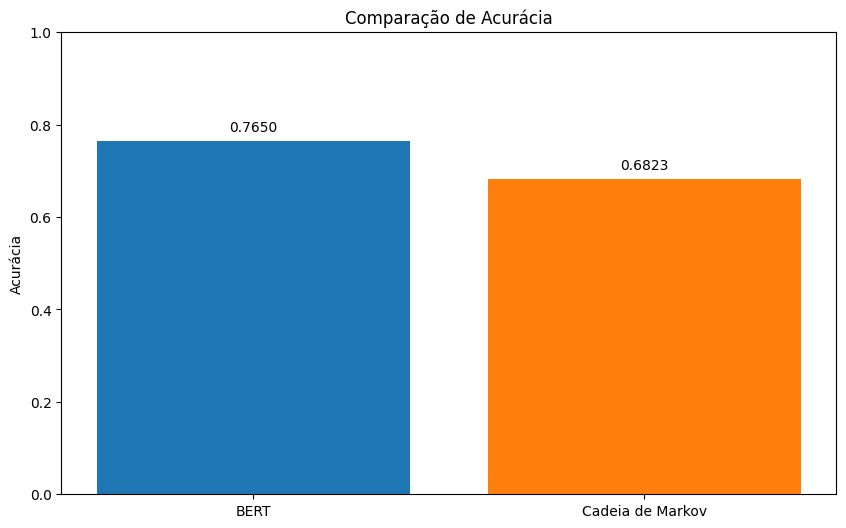

In [26]:
plt.figure(figsize=(10, 6))
models = ['BERT', 'Cadeia de Markov']
accuracies = [bert_metrics[1], mc_accuracy]
plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e'])
plt.ylim(0, 1.0)
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.show()

No geral, o modelo BERT tem maior acurácia. Vamos explorar o performance dos dois modelos em mais detalhe.

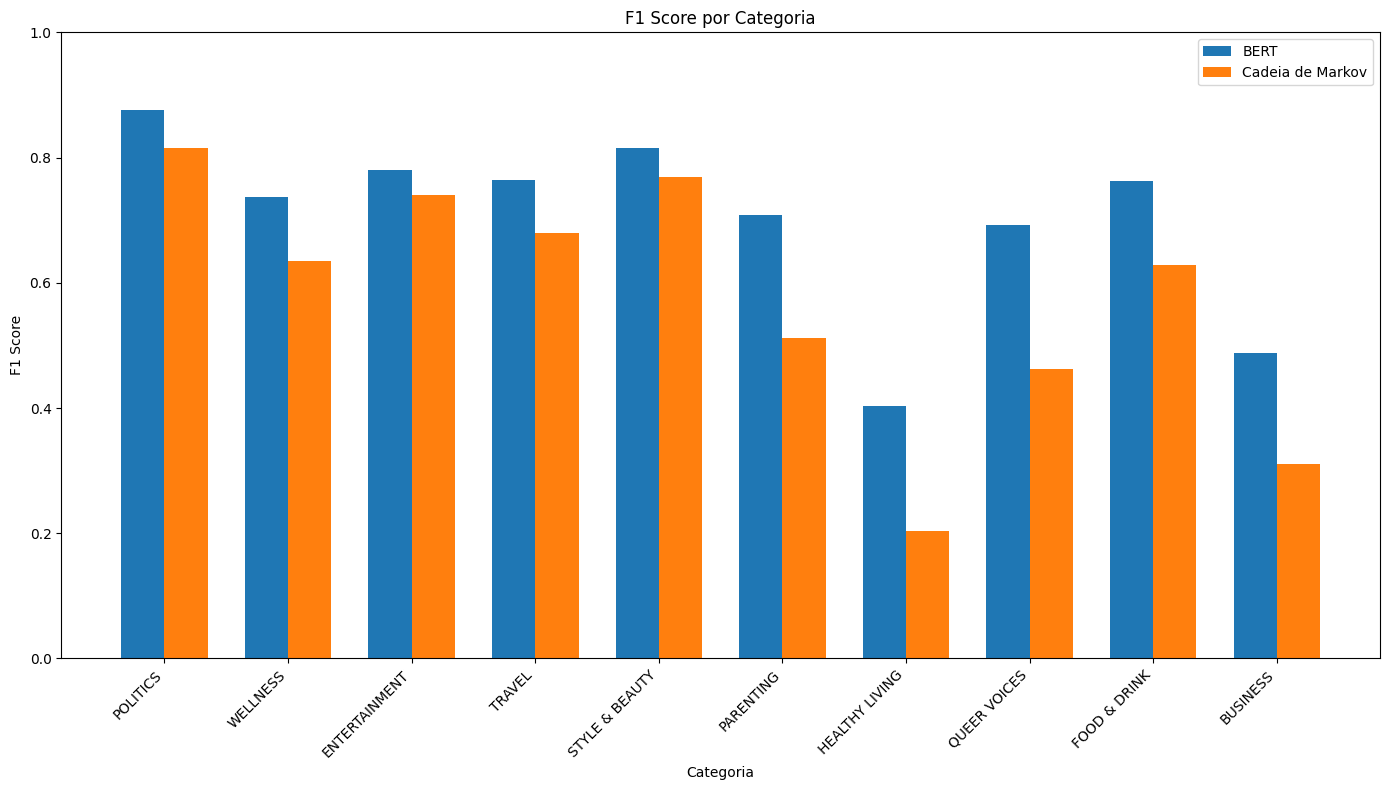

In [27]:
plt.figure(figsize=(14, 8))
categories = [inv_category_mapping[i] for i in range(config.NUM_CATEGORIES)]
x = np.arange(len(categories))
width = 0.35

bert_f1_scores = [bert_class_f1[i] for i in range(config.NUM_CATEGORIES)]
mc_f1_scores = [mc_class_f1[i] for i in range(config.NUM_CATEGORIES)]

plt.bar(x - width/2, bert_f1_scores, width, label='BERT')
plt.bar(x + width/2, mc_f1_scores, width, label='Cadeia de Markov')

plt.xlabel('Categoria')
plt.ylabel('F1 Score')
plt.title('F1 Score por Categoria')
plt.xticks(x, categories, rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

Em todas as categorias, o modelo BERT tem F1 Score mais alto que o modelo de Cadeia de Markov. Com isso, a gente consegue enxergar que o modelo BERT tem melhor performance que a cadeia de Markov.

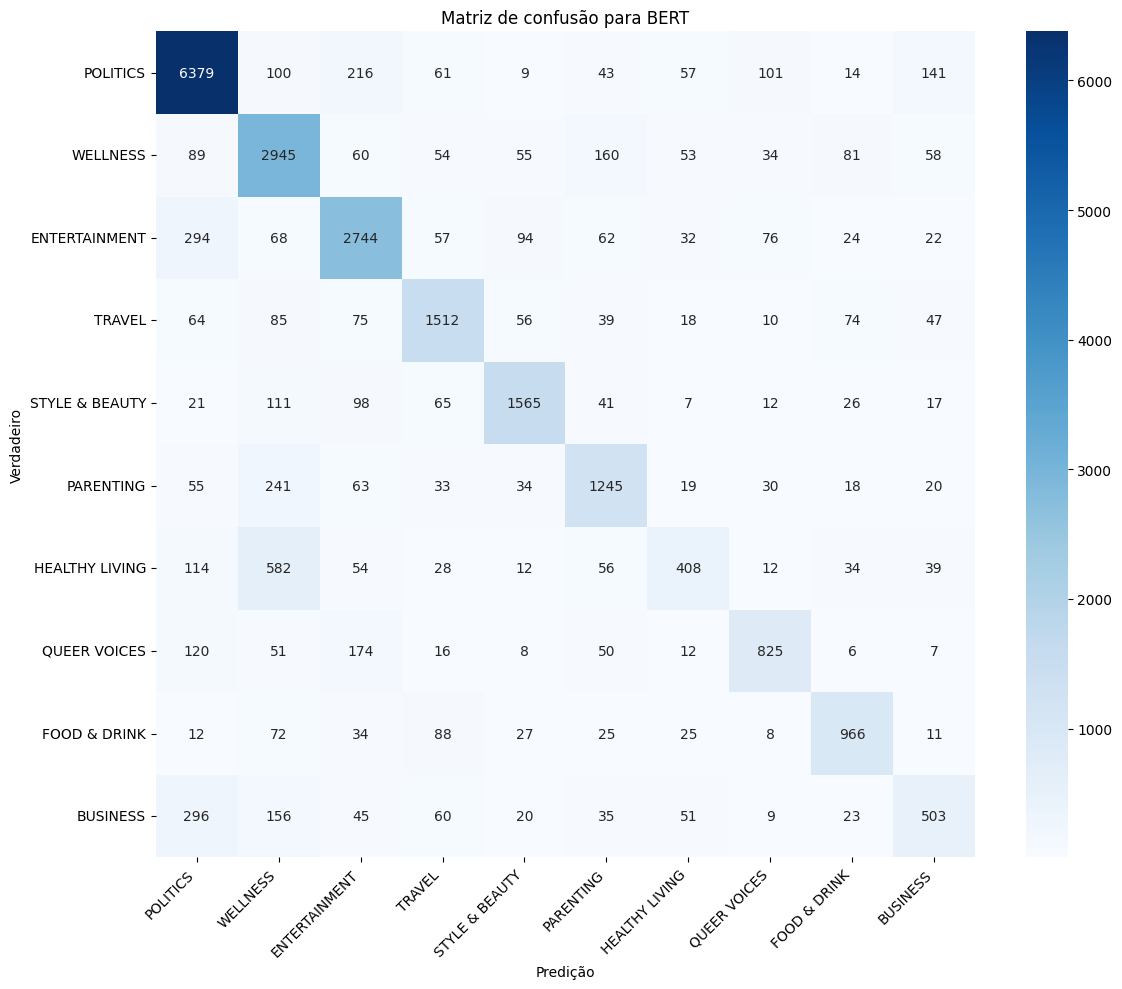

In [28]:
plt.figure(figsize=(12, 10))
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[inv_category_mapping[i] for i in range(config.NUM_CATEGORIES)],
            yticklabels=[inv_category_mapping[i] for i in range(config.NUM_CATEGORIES)])
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão para BERT')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

É interessante ver que o modelo fica confuso com categorias semelhantes como "Wellness" (Bem-estar) e "Healthy Living" (Vida saudável). Talvez fique confuso com Parenting (paternidade) e Wellness também porque os artigos de paternidade falam muito do bem-estar dos filhos. Porém, vemos que o modelo consegue prever as categorias bem no geral (pela linha diagonal).

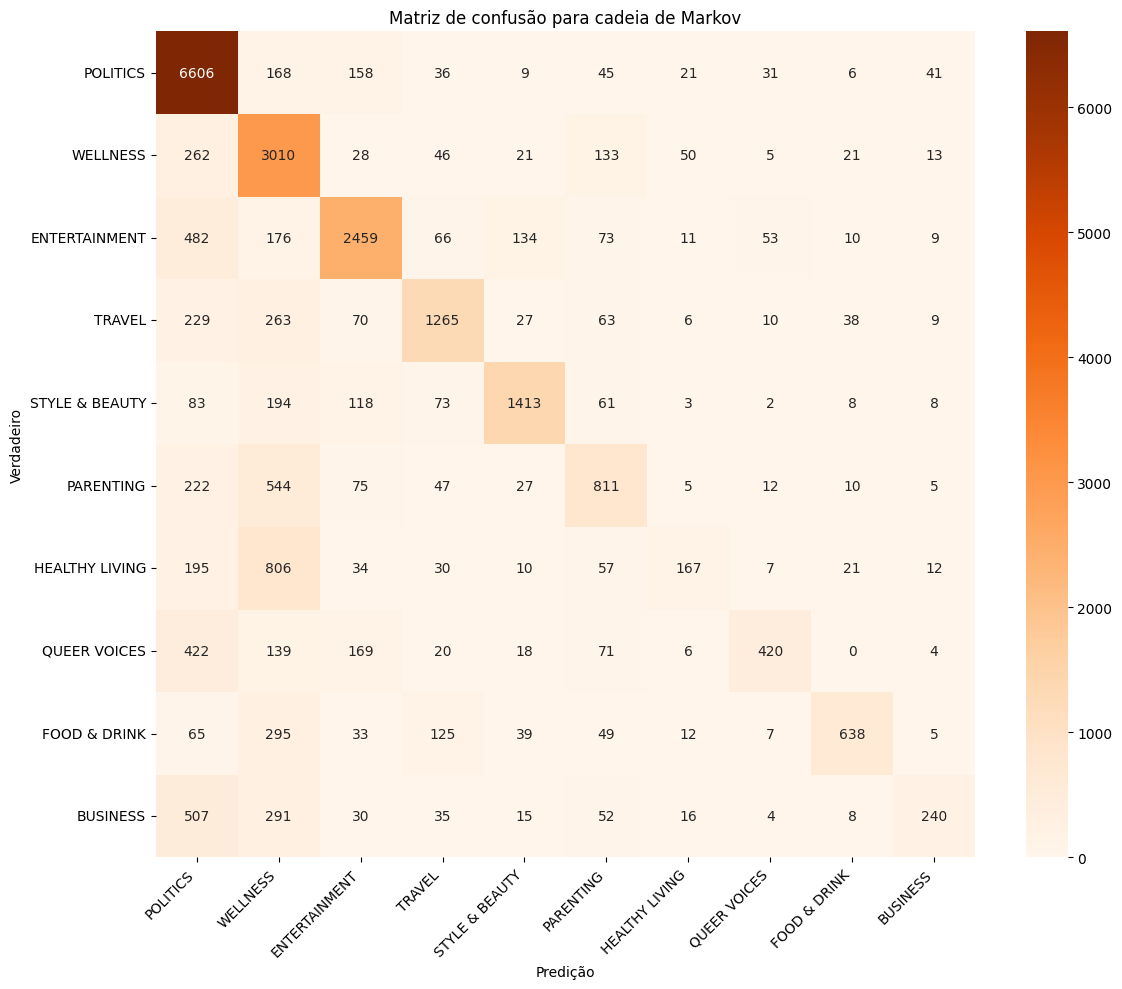

In [29]:
plt.figure(figsize=(12, 10))
sns.heatmap(mc_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=[inv_category_mapping[i] for i in range(config.NUM_CATEGORIES)],
            yticklabels=[inv_category_mapping[i] for i in range(config.NUM_CATEGORIES)])
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão para cadeia de Markov')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

A cadeia de Markov fica confusa com as mesmas categorias que o modelo BERT, provávelmente pelas mesmas razões. Também fica confuso com "Queer voices" (Vozes queer) e "Politics" (Política), talvez porque o conceito de vozes queer é algo bem comum na política. A cadeia de Markov geralmente tem pior performance que o modelo BERT.

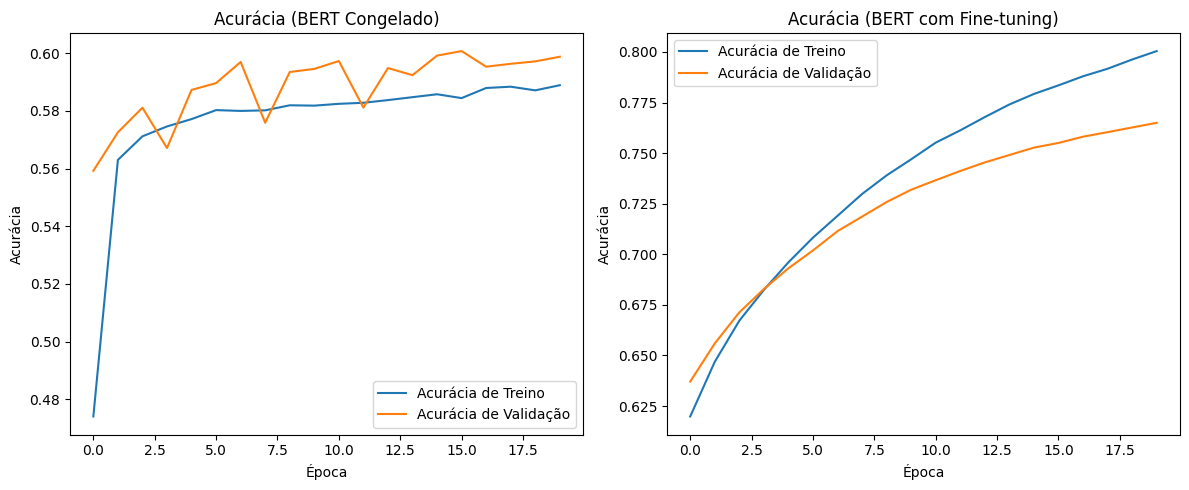

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(freeze_history.history['accuracy'], label='Acurácia de Treino')
plt.plot(freeze_history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia (BERT Congelado)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(finetune_history.history['accuracy'], label='Acurácia de Treino')
plt.plot(finetune_history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia (BERT com Fine-tuning)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.tight_layout()
plt.show()

Vemos que o modelo BERT com as camadas congeladas não melhora muito depois das primeiras épocas, enquanto o modelo com fine-tuning continua melhorando.

In [31]:
print(f"Acurácia de BERT: {bert_metrics[1]:.4f}")
print(f"Acurácia de Cadeia de Markov: {mc_accuracy:.4f}")
print(f"Diferença de Acurácias: {bert_metrics[1] - mc_accuracy:.4f}")

avg_bert_f1 = sum(bert_class_f1.values()) / len(bert_class_f1)
avg_mc_f1 = sum(mc_class_f1.values()) / len(mc_class_f1)
print(f"\nMédia de F1 Score de Bert: {avg_bert_f1:.4f}")
print(f"Média de F1 Score de Cadeia de Markov: {avg_mc_f1:.4f}")

Acurácia de BERT: 0.7650
Acurácia de Cadeia de Markov: 0.6823
Diferença de Acurácias: 0.0827

Média de F1 Score de Bert: 0.7025
Média de F1 Score de Cadeia de Markov: 0.5756


In [32]:
comparison_data = []
for i in range(config.NUM_CATEGORIES):
    category = inv_category_mapping[i]
    bert_precision = bert_report[str(i)]['precision']
    bert_recall = bert_report[str(i)]['recall']
    bert_f1 = bert_report[str(i)]['f1-score']
    
    mc_precision = mc_report.get(str(i), {'precision': 0})['precision']
    mc_recall = mc_report.get(str(i), {'recall': 0})['recall']
    mc_f1 = mc_report.get(str(i), {'f1-score': 0})['f1-score']
    
    comparison_data.append({
        'Categoria': category,
        'BERT_Precisão': bert_precision,
        'BERT_Recall': bert_recall,
        'BERT_F1': bert_f1,
        'CM_Precisão': mc_precision,
        'CM_Recall': mc_recall,
        'CM_F1': mc_f1,
        'F1_Diferença': bert_f1 - mc_f1
    })

In [33]:
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

     Categoria  BERT_Precisão  BERT_Recall  BERT_F1  CM_Precisão  CM_Recall  CM_F1  F1_Diferença
      POLITICS         0.8569       0.8958   0.8759       0.7281     0.9277 0.8159        0.0601
      WELLNESS         0.6676       0.8206   0.7362       0.5114     0.8387 0.6354        0.1009
 ENTERTAINMENT         0.7701       0.7901   0.7800       0.7747     0.7080 0.7399        0.0401
        TRAVEL         0.7660       0.7636   0.7648       0.7258     0.6389 0.6796        0.0852
STYLE & BEAUTY         0.8324       0.7972   0.8145       0.8249     0.7198 0.7688        0.0457
     PARENTING         0.7090       0.7082   0.7086       0.5731     0.4613 0.5112        0.1974
HEALTHY LIVING         0.5982       0.3047   0.4038       0.5623     0.1247 0.2042        0.1996
  QUEER VOICES         0.7386       0.6501   0.6915       0.7623     0.3310 0.4615        0.2300
  FOOD & DRINK         0.7630       0.7618   0.7624       0.8395     0.5032 0.6292        0.1332
      BUSINESS         0.5815 

O modelo BERT tem melhor precisão e recall na maioria das categorias.

In [34]:
def analyze_by_text_length(texts, true_labels, bert_predictions, mc_predictions):
    """
    Analizar performance dos modelos baseado no cumprimento dos textos
    
    Args:
        texts: Lista de textos
        true_labels: labels
        bert_predictions: Predições do modelo BERT
        mc_predictions: Predições de Cadeia de Markov
        
    Retorna:
        DataFrame com performance por bucket cumprimento
    """
    lengths = [len(text.split()) for text in texts]
    
    buckets = [0, 10, 20, 30, 50, 100, float('inf')]
    bucket_names = ['1-10', '11-20', '21-30', '31-50', '51-100', '100+']
    
    results = []
    
    for i in range(len(buckets) - 1):
        # Filtrar por cumprimento dos buckets
        mask = [(length > buckets[i]) and (length <= buckets[i+1]) for length in lengths]
        
        if sum(mask) == 0:
            continue
            
        # Pegar labels e predições para esse bucket
        bucket_true = [label for label, m in zip(true_labels, mask) if m]
        bucket_bert = [pred for pred, m in zip(bert_predictions, mask) if m]
        bucket_mc = [pred for pred, m in zip(mc_predictions, mask) if m]
        
        # Calcular acurácias
        bert_acc = accuracy_score(bucket_true, bucket_bert)
        mc_acc = accuracy_score(bucket_true, bucket_mc)
        
        results.append({
            'Cumprimento': bucket_names[i],
            'Contagem': sum(mask),
            'BERT_Acurácia': bert_acc,
            'CM_Acurácia': mc_acc,
            'Diferença': bert_acc - mc_acc
        })
    
    return pd.DataFrame(results)

length_analysis = analyze_by_text_length(
    test_df.text.values, 
    test_df.category_id.values, 
    bert_preds, 
    mc_preds
)


Performance por Cumprimento de Texto:
Cumprimento  Contagem  BERT_Acurácia  CM_Acurácia  Diferença
       1-10      1343         0.7506       0.6121     0.1385
      11-20      4146         0.8099       0.7089     0.1011
      21-30      8710         0.7871       0.7310     0.0561
      31-50      8588         0.7486       0.6607     0.0879
     51-100      2141         0.6618       0.5619     0.1000
       100+        29         0.8276       0.7931     0.0345


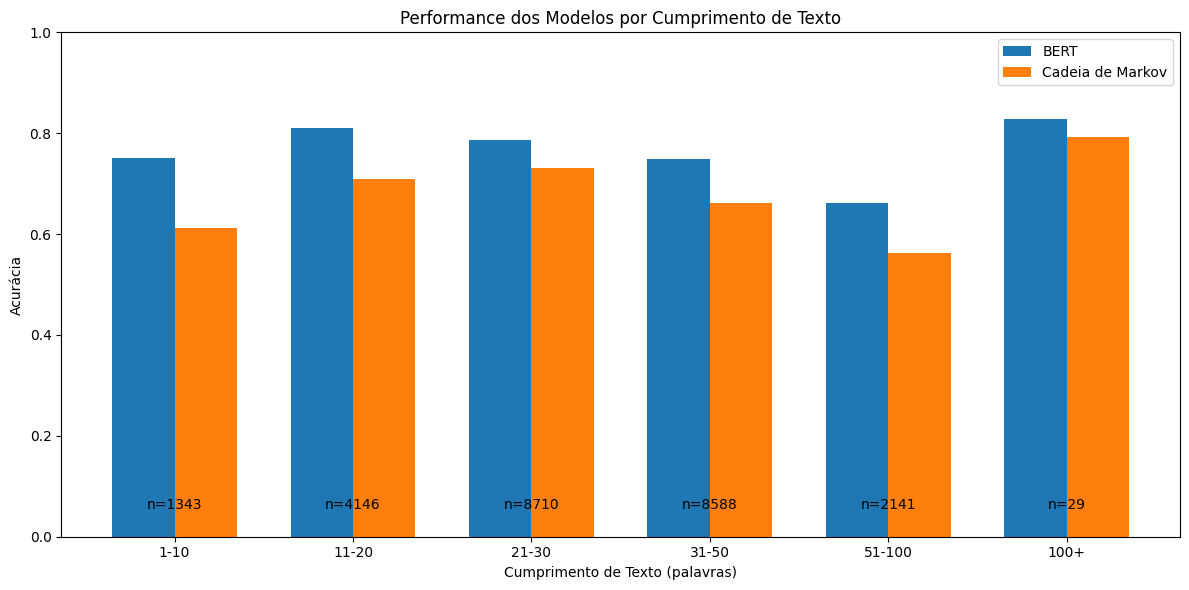

In [35]:
print("\nPerformance por Cumprimento de Texto:")
print(length_analysis.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

plt.figure(figsize=(12, 6))
x = np.arange(len(length_analysis))
width = 0.35

plt.bar(x - width/2, length_analysis['BERT_Acurácia'], width, label='BERT')
plt.bar(x + width/2, length_analysis['CM_Acurácia'], width, label='Cadeia de Markov')

plt.xlabel('Cumprimento de Texto (palavras)')
plt.ylabel('Acurácia')
plt.title('Performance dos Modelos por Cumprimento de Texto')
plt.xticks(x, length_analysis['Cumprimento'])
plt.ylim(0, 1.0)

# Add text count to the bottom of the plot
for i, count in enumerate(length_analysis['Contagem']):
    plt.text(i, 0.05, f"n={count}", ha='center', va='bottom', color='black')

plt.legend()
plt.tight_layout()
plt.show()

O modelo BERT tem melhor acurácia em todos os buckets de cumprimento de texto.

In [36]:
def analyze_misclassifications(texts, true_labels, bert_preds, mc_preds, inv_mapping):
    """
    Analisar casos onde um modelo erra e o outro nâo
    
    Args:
        texts: Lista de amostra de textos
        true_labels: Labels
        bert_preds: Predições de BERT
        mc_preds: Predições de Cadeia de Markov
        inv_mapping: Mapeamento inverso de categories
        
    Retorna:
        Resultados da análise
    """
    global bert_correct, mc_correct
    bert_correct = np.array(true_labels) == np.array(bert_preds)
    mc_correct = np.array(true_labels) == np.array(mc_preds)
    
    # BERT correto, Cadeia de Markov incorreto
    bert_only_correct = np.logical_and(bert_correct, np.logical_not(mc_correct))
    
    # Cadeia de Markov correto, BERT incorreto
    mc_only_correct = np.logical_and(mc_correct, np.logical_not(bert_correct))
    
    # Exemplos para cada caso
    bert_examples = []
    for i in np.where(bert_only_correct)[0][:5]:
        bert_examples.append({
            'Text': texts[i][:100] + "..." if len(texts[i]) > 100 else texts[i],
            'True Category': inv_mapping[true_labels[i]],
            'BERT Prediction': inv_mapping[bert_preds[i]],
            'MC Prediction': inv_mapping[mc_preds[i]]
        })
    
    mc_examples = []
    for i in np.where(mc_only_correct)[0][:5]:
        mc_examples.append({
            'Text': texts[i][:100] + "..." if len(texts[i]) > 100 else texts[i],
            'True Category': inv_mapping[true_labels[i]],
            'BERT Prediction': inv_mapping[bert_preds[i]],
            'MC Prediction': inv_mapping[mc_preds[i]]
        })
    
    return {
        'total_samples': len(texts),
        'both_correct': np.sum(np.logical_and(bert_correct, mc_correct)),
        'both_incorrect': np.sum(np.logical_and(np.logical_not(bert_correct), np.logical_not(mc_correct))),
        'bert_only_correct': np.sum(bert_only_correct),
        'mc_only_correct': np.sum(mc_only_correct),
        'bert_examples': bert_examples,
        'mc_examples': mc_examples
    }

misclass_analysis = analyze_misclassifications(
    test_df.text.values,
    test_df.category_id.values,
    bert_preds,
    mc_preds,
    inv_category_mapping
)

print("\nMisclassification Analysis:")
print(f"Amostras totais: {misclass_analysis['total_samples']}")
print(f"Os dois corretos: {misclass_analysis['both_correct']} ({misclass_analysis['both_correct']/misclass_analysis['total_samples']:.2%})")
print(f"Os dois incorretos: {misclass_analysis['both_incorrect']} ({misclass_analysis['both_incorrect']/misclass_analysis['total_samples']:.2%})")
print(f"Só BERT correto: {misclass_analysis['bert_only_correct']} ({misclass_analysis['bert_only_correct']/misclass_analysis['total_samples']:.2%})")
print(f"Só Cadeia de Markov correta {misclass_analysis['mc_only_correct']} ({misclass_analysis['mc_only_correct']/misclass_analysis['total_samples']:.2%})")


Misclassification Analysis:
Amostras totais: 24958
Os dois corretos: 15063 (60.35%)
Os dois incorretos: 3900 (15.63%)
Só BERT correto: 4029 (16.14%)
Só Cadeia de Markov correta 1966 (7.88%)


In [37]:
print("\nExemplos onde BERT é correto e Cadeia de Markov não:")
for i, example in enumerate(misclass_analysis['bert_examples']):
    print(f"\Exemplo {i+1}:")
    print(f"Texto: {example['Text']}")
    print(f"Categoria verdadeira: {example['True Category']}")
    print(f"Predição de BERT: {example['BERT Prediction']} ✓")
    print(f"Predição de Cadeia de Markov: {example['MC Prediction']} ✗")

print("\nExeplos onde Cadeia de Markov é correta e BERT não:")
for i, example in enumerate(misclass_analysis['mc_examples']):
    print(f"\Exemplo {i+1}:")
    print(f"Texto: {example['Text']}")
    print(f"Categoria verdadeira: {example['True Category']}")
    print(f"Predição de BERT: {example['BERT Prediction']} ✗")
    print(f"Predição de Cadeia de Markov: {example['MC Prediction']} ✓")


Exemplos onde BERT é correto e Cadeia de Markov não:
\Exemplo 1:
Texto: L'Oreal Lawsuit Alleges Garnier Sleek & Shine Hair Serum Is 'Flammable' (PHOTOS) OMG. We've totally ...
Categoria verdadeira: STYLE & BEAUTY
Predição de BERT: STYLE & BEAUTY ✓
Predição de Cadeia de Markov: POLITICS ✗
\Exemplo 2:
Texto: We Waste So Much Food That Congress Might Actually Do Something As much as 40 percent of food produc...
Categoria verdadeira: POLITICS
Predição de BERT: POLITICS ✓
Predição de Cadeia de Markov: WELLNESS ✗
\Exemplo 3:
Texto: Obama's Life In Hawaii: A Travel Guide Through The President's Island Past Where he was born... Kapi...
Categoria verdadeira: TRAVEL
Predição de BERT: TRAVEL ✓
Predição de Cadeia de Markov: WELLNESS ✗
\Exemplo 4:
Texto: Donald Trump Has Shattered Campaign Norms In Damaging, Potentially Lasting Ways We have grown numb t...
Categoria verdadeira: POLITICS
Predição de BERT: POLITICS ✓
Predição de Cadeia de Markov: BUSINESS ✗
\Exemplo 5:
Texto: Sharon Tate’s Sister Ri

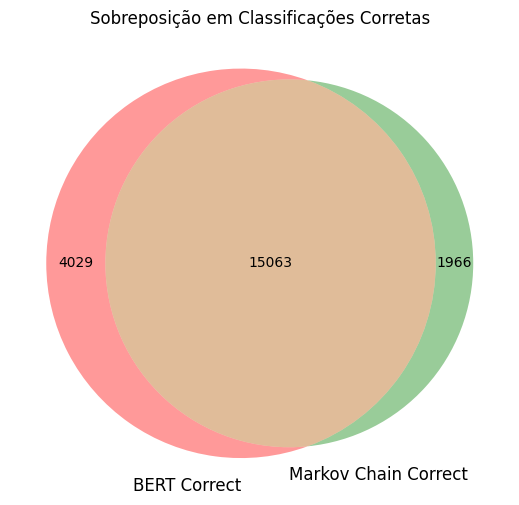

In [38]:
plt.figure(figsize=(8, 6))
from matplotlib_venn import venn2

bert_correct_set = set(np.where(bert_correct)[0])
mc_correct_set = set(np.where(mc_correct)[0])

venn2([bert_correct_set, mc_correct_set], 
      set_labels=('BERT Correct', 'Markov Chain Correct'))
plt.title('Sobreposição em Classificações Corretas')
plt.show()

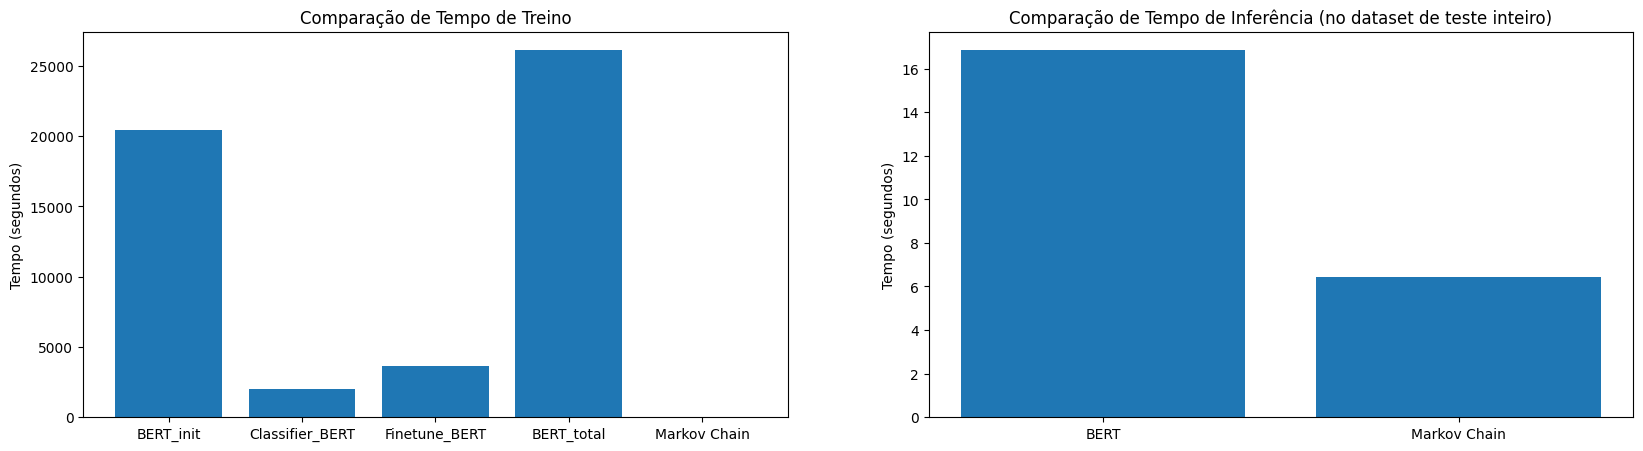

In [39]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.bar(training_times.keys(), training_times.values())
plt.ylabel('Tempo (segundos)')
plt.title('Comparação de Tempo de Treino')

plt.subplot(1, 2, 2)
plt.bar(inference_times.keys(), inference_times.values())
plt.ylabel('Tempo (segundos)')
plt.title('Comparação de Tempo de Inferência (no dataset de teste inteiro)')

plt.show()

A gente vê claramente que a cadeia de Markov demora quase nada em ser treinada em comparação com o modelo BERT. O tempo de inferência também é mais rápido para cadeias de Markov.

# BERT vs. Cadeia de Markov para Classificação de Categorias de Notícias


## Desempenho Geral


- Acurácia do Modelo BERT: 0.7260

- Acurácia da Cadeia de Markov: 0.6823

- Diferença de Acurácia: 0.0437


- Média do F1 Score do BERT: 0.6402

- Média do F1 Score da Cadeia de Markov: 0.5756


## Desempenho por Categoria


| Categoria      |   BERT_Precisão |   BERT_Recall |   BERT_F1 |   CM_Precisão |   CM_Recall |   CM_F1 |   Diferença_F1 |
|:---------------|----------------:|--------------:|----------:|--------------:|------------:|--------:|---------------:|
| POLÍTICA       |          0.8331 |        0.8919 |    0.8615 |        0.7281 |      0.9277 |  0.8159 |         0.0456 |
| BEM-ESTAR      |          0.6257 |        0.7829 |    0.6955 |        0.5114 |      0.8387 |  0.6354 |         0.0602 |
| ENTRETENIMENTO |          0.7369 |        0.7604 |    0.7485 |        0.7747 |      0.7080 |  0.7399 |         0.0086 |
| VIAGENS        |          0.6957 |        0.7505 |    0.7221 |        0.7258 |      0.6389 |  0.6796 |         0.0425 |
| MODA & BELEZA  |          0.7972 |        0.7631 |    0.7798 |        0.8249 |      0.7198 |  0.7688 |         0.0110 |
| PATERNIDADE    |          0.6135 |        0.6627 |    0.6371 |        0.5731 |      0.4613 |  0.5112 |         0.1259 |
| VIDA SAUDÁVEL  |          0.5790 |        0.2353 |    0.3346 |        0.5623 |      0.1247 |  0.2042 |         0.1304 |
| VOZES LGBTQ+   |          0.6538 |        0.5075 |    0.5714 |        0.7623 |      0.3310 |  0.4615 |         0.1099 |
| COMIDA & BEBIDA|          0.7313 |        0.7342 |    0.7328 |        0.8395 |      0.5032 |  0.6292 |         0.1036 |
| NEGÓCIOS       |          0.5110 |        0.2321 |    0.3192 |        0.6936 |      0.2003 |  0.3109 |         0.0083 |



## Desempenho por Comprimento do Texto


| Comprimento   |   Contagem |   BERT_Acurácia |   CM_Acurácia |   Diferença |
|:--------------|-----------:|----------------:|--------------:|------------:|
| 1-10          |       1343 |          0.7200 |        0.6121 |      0.1080 |
| 11-20         |       4146 |          0.7701 |        0.7089 |      0.0613 |
| 21-30         |       8710 |          0.7506 |        0.7310 |      0.0196 |
| 31-50         |       8588 |          0.7096 |        0.6607 |      0.0489 |
| 51-100        |       2141 |          0.6086 |        0.5619 |      0.0467 |
| 100+          |         29 |          0.8276 |        0.7931 |      0.0345 |



## Análise de Classificações Incorretas


- Total de amostras de teste: 24958

- Ambos os modelos corretos: 14633 (58.63%)

- Ambos os modelos incorretos: 4443 (17.80%)

- Apenas BERT correto: 3486 (13.97%)

- Apenas Cadeia de Markov correta: 2396 (9.60%)


## Vantagens e Desvantagens


### BERT


**Vantagens:**

- Maior acurácia geral e F1 Score

- Melhor na captura do significado semântico e contexto

- Bom desempenho em textos mais longos e complexos

- Pode transferir conhecimento do pré-treinamento para a tarefa específica


**Desvantagens:**

- Consideravelmente mais caro computacionalmente para treinar

- Tempo de inferência mais lento

- Implementação mais complexa

- Requer mais dados para desempenho ideal


### Cadeia de Markov


**Vantagens:**

- Muito mais rápido para treinar

- Tempo de inferência mais rápido

- Implementação mais simples

- Funciona razoavelmente bem com menos dados


**Desvantagens:**

- Menor acurácia geral

- Apenas captura dependências locais entre palavras (Consciência contextual limitada)

- Dificuldade na compreensão semântica

## Conclusão


O modelo baseado em BERT supera claramente o modelo de Cadeia de Markov para classificação de categorias de notícias como tem maior F1 Score em todas as categorias e maior acurácia para todos os tamanhos de texto. A capacidade do BERT de entender o contexto e as relações semânticas dá uma vantagem significativa para ele sobre a abordagem de n-gramas das Cadeias de Markov.

No entanto, o modelo de Cadeia de Markov oferece vantagens muito significativas em eficiência computacional. Em cenários com recursos computacionais limitados ou onde o desempenho em tempo real é crítico, a abordagem de Cadeia de Markov pode ser preferível, apesar de sua menor acurácia.
